In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Simulation of Random Walk and it's Analysis (Stochastic Simulation)

---------------------------
CPU scalar: 164.9
CPU vectorized1: 2.2
CPU scalar/vectorized1: 74.7
CPU vectorized2: 1.6
CPU scalar/vectorized2: 102.9
---------------------------
histogram times: [  0 100 200 300 400 500 600 700 800 900]
random walk: 0.0s


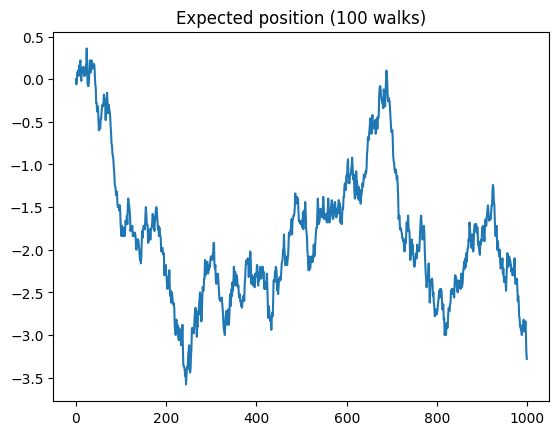

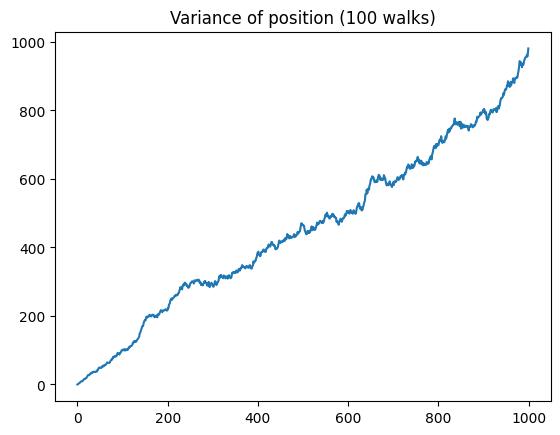

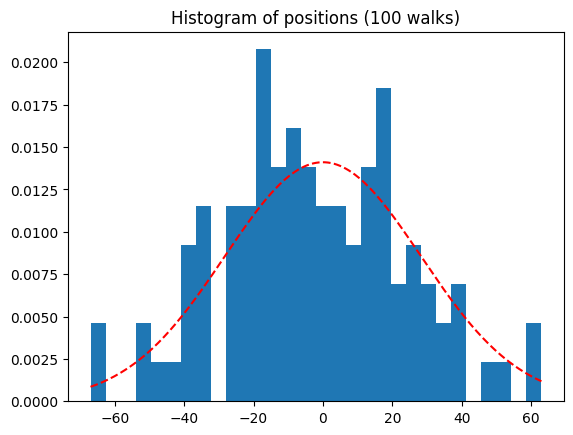

histogram times: [  0 100 200 300 400 500 600 700 800 900]
random walk: 0.8s


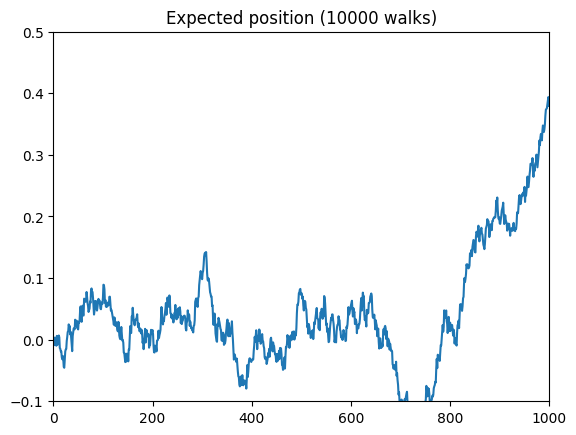

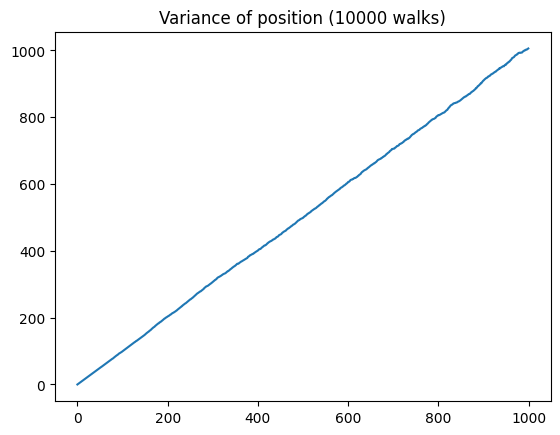

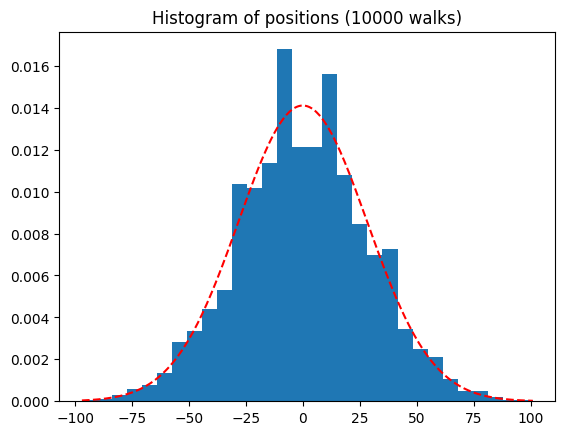

histogram times: [  0 100 200 300 400 500 600 700 800 900]
random walk: 7.2s


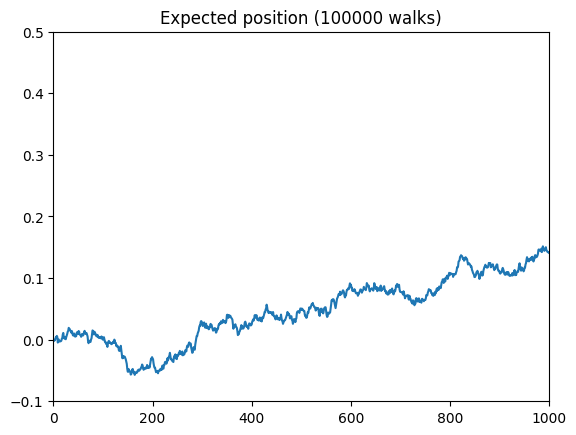

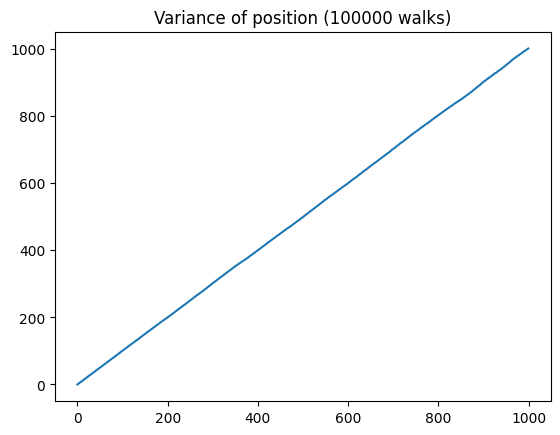

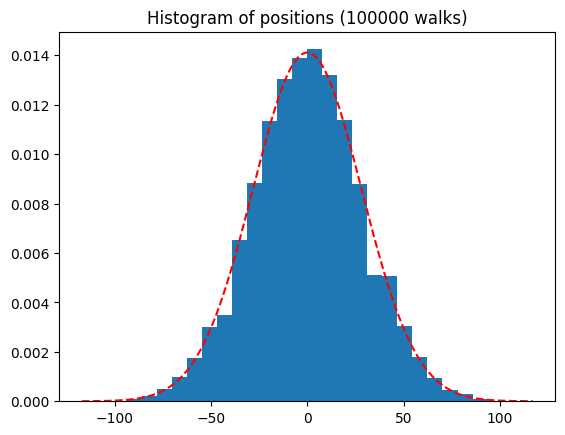

histogram times: [  0 100 200 300 400 500 600 700 800 900]
random walk: 59.3s


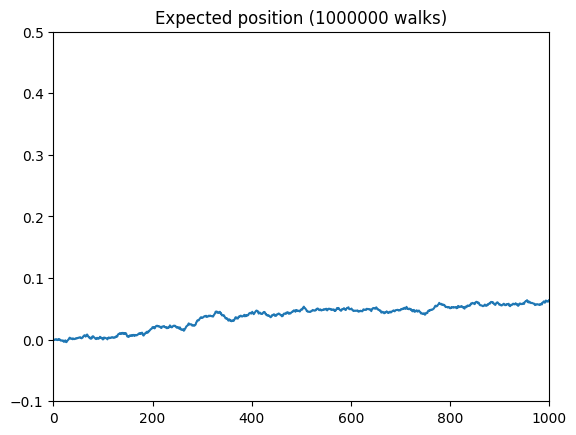

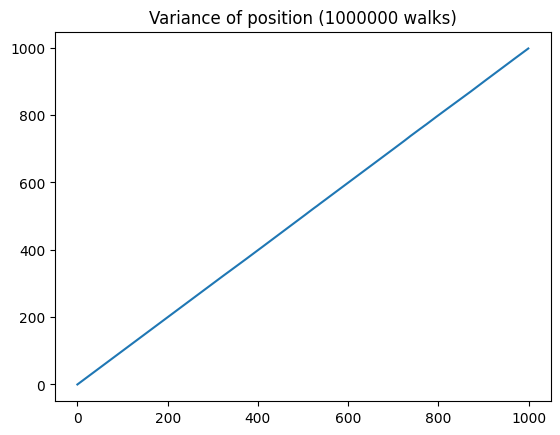

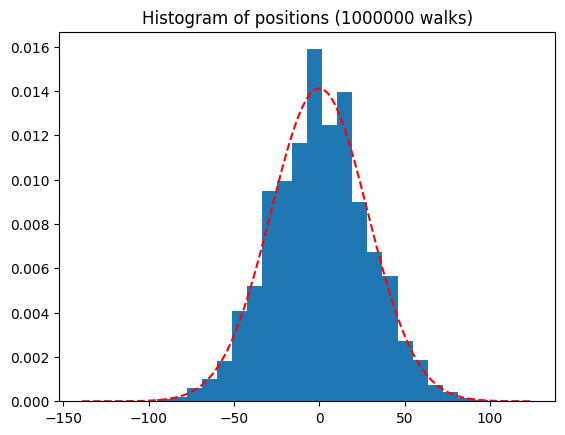

---------------------------


In [13]:
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(10) # ensures reproducibility of results.
np.random.seed(10)

def random_walks1D(x0, N, p, num_walks=1, num_times=1, random=random):

    """
    Simulates num_walks random walks from x0 with N steps.

    Parameters:
    - x0: Initial position of the random walk.
    - N: Number of steps in each random walk.
    - p: Probability of moving to the left (-1) at each step.
    - num_walks: Number of random walks to simulate.
    - num_times: Number of times to record positions during each walk.
    - random: Random number generator function (default: Python's random module).

    Returns:
    - position: Array of positions at each step for each walk.
    - position2: Array of squared positions at each step for each walk.
    - pos_hist: Array of recorded positions at specified times for each walk.
    - pos_hist_times: Array of times at which positions are recorded.
    """


    position = np.zeros(N)
    position[0] = x0
    position2 = np.zeros(N)
    position2[0] = x0**2
    pos_hist = np.zeros((num_walks, num_times))
    pos_hist_times = [(N//num_times)*i for i in range(num_times)] # list of times at which positions are recorded during each walk.

    for n in range(num_walks):
        num_times_counter = 0
        current_pos = x0
        for k in range(N - 1):
            if k in pos_hist_times:
                pos_hist[n,num_times_counter] = current_pos
                num_times_counter += 1
            r = random.uniform(0, 1)
            if r <= p:
                current_pos -= 1
            else:
                current_pos += 1
            position[k+1] += current_pos
            position2[k+1] += current_pos**2
    return position, position2, pos_hist, np.array(pos_hist_times)

def random_walks1D_vec1(x0, N, p, num_walks=1, num_times=1):
    """Vectorized version of random_walks1D."""
    position = np.zeros(N)
    position2 = np.zeros(N)
    pos_hist = np.zeros((num_walks, num_times))
    pos_hist_times = [(N//num_times)*i for i in range(num_times)]

    for n in range(num_walks):
        r = np.random.uniform(0, 1, size=N - 1)
        steps = np.where(r <= p, -1, 1)
        current_pos = x0 + np.cumsum(steps)
        position += np.concatenate(([x0], current_pos))
        position2 += np.concatenate(([x0**2], current_pos**2))
        pos_hist[n,:] = current_pos[pos_hist_times]
    return position, position2, pos_hist, np.array(pos_hist_times)

def random_walks1D_vec2(x0, N, p, num_walks=1, num_times=1):
      """
    Demonstration of random walk simulations and statistical analysis.

    Parameters:
    - N: Number of steps in each random walk.
    - num_walks: Number of random walks to simulate.
    - EX_minmax: Min and Max values for the plot axis (optional).

    Generates plots of expected position, variance, and histograms of random walk positions.
    """

    position = np.zeros(N)
    position2 = np.zeros(N)
    walks = np.zeros((num_walks, N))
    walks[:,0] = x0
    pos_hist = np.zeros((num_walks, num_times))
    pos_hist_times = [(N//num_times)*i for i in range(num_times)]

    r = np.random.uniform(0, 1, size=(num_walks, N - 1))
    steps = np.where(r <= p, -1, 1)
    walks[:,1:] = x0 + np.cumsum(steps, axis=1)
    position = np.sum(walks, axis=0)
    position2 = np.sum(walks**2, axis=0)
    pos_hist[:,:] = walks[:,pos_hist_times]
    return position, position2, pos_hist, np.array(pos_hist_times)

def test_random_walks1D():
    x0 = 0
    N = 4
    p = 0.5
    num_walks = 3
    num_times = N

    np.random.seed(10)
    serial_computed = random_walks1D(x0, N, p, num_walks, num_times, random=np.random)
    np.random.seed(10)
    vectorized1_computed = random_walks1D_vec1(x0, N, p, num_walks, num_times)
    np.random.seed(10)
    vectorized2_computed = random_walks1D_vec2(x0, N, p, num_walks, num_times)

    # assertion in certain tolerance level

    for s, v in zip(serial_computed, vectorized1_computed):
        assert np.allclose(s, v)

    for s, v in zip(serial_computed, vectorized2_computed):
        assert np.allclose(s, v)

def demo_random_walks1D(N=1000, num_walks=10000, EX_minmax=None):
    import time


    """
    Demonstration of random walk simulations and statistical analysis.

    Parameters:
    - N: Number of steps in each random walk.
    - num_walks: Number of random walks to simulate.
    - EX_minmax: Min and Max values for the plot axis (optional).

    Generates plots of expected position, variance, and histograms of random walk positions.
    """

    t0 = time.process_time()
    pos, pos2, hist, hist_times = random_walks1D_vec1(x0=0, N=N, p=0.5, num_walks=num_walks, num_times=10,)
    t1 = time.process_time()

    # Print Execution Information

    print('histogram times:', hist_times)
    print('random walk: %.1fs' % (t1-t0))

    # Calculate Expectation and Variance

    E_X = pos/float(num_walks)
    Var_X = pos2/float(num_walks) - E_X**2

    plt.figure()
    plt.plot(E_X)
    if EX_minmax is not None:
        plt.axis([0, N, EX_minmax[0], EX_minmax[1]])
    plt.title('Expected position (%d walks)' % num_walks)
    plt.savefig('tmp1.png')
    plt.savefig('tmp1.pdf')

    plt.figure()
    plt.plot(Var_X)
    plt.title('Variance of position (%d walks)' % num_walks)
    plt.savefig('tmp2.png')
    plt.savefig('tmp2.pdf')

    plt.figure()
    a = 0.5

    # Produces histogram of the walk positions at a particular recorded time (specified by hist_time_index).
    # Also plots a theoretical distribution (Gaussian) to compare with the histogram, showing the expected statistical behavior according to the diffusion equation model.

    exact = lambda x, t: 1./np.sqrt(4*np.pi*t*a)*np.exp(-x**2/(4.0*t*a))
    hist_time_index = -2

    # Matplotlib function used to create a histogram

    n, bins, patches = plt.hist(hist[:,hist_time_index], bins=30, density=True)

  #  bins(=30) specifies that the histogram should be divided into 30 equally sized bins,
  #  these are the intervals in which the data values will be grouped.
  #  density(=True) implies the histogram is normalized such that the integral of the histogram (area under the curve) equals 1.
  #  This makes it a probability density, which can be compared directly to probability density functions from theoretical distributions.

    x = np.linspace(bins[0], bins[-1], 301)
    t = hist_times[hist_time_index]
    plt.plot(x, exact(x, t), 'r--')
    plt.title('Histogram of positions (%d walks)' % num_walks)
    plt.savefig('tmp3.png')
    plt.savefig('tmp3.pdf')
    plt.show()

def demo_fig_random_walks1D():

    """
    Demonstration of random walk simulations with varying numbers of walks.

    Generates multiple figures showing statistical analysis of random walks with different numbers of simulations.
    """

    import shutil, os # modules for file management tasks such as deleting directories and moving files.
    N = 1000
    num_walks = [100, 10000, 100000, 1000000]
    for n in num_walks:
        np.random.seed(10)  
        if n == 100:
            demo_random_walks1D(N=N, num_walks=n, EX_minmax=None)
        else:
            demo_random_walks1D(N=N, num_walks=n, EX_minmax=[-0.1, 0.5])

        # Create a directory and move generated plots into it
        d = 'tmp_%d' % n
        if os.path.isdir(d):
            shutil.rmtree(d)
        os.mkdir(d)
        for p in 1,2,3:
            os.rename('tmp%d.png' % p, os.path.join(d, 'tmp%d.png' % p))
            os.rename('tmp%d.pdf' % p, os.path.join(d, 'tmp%d.pdf' % p))

def demo_random_walks1D_timing():
    """
    Measure and compare the execution time of different random walk implementations.

    """
    import time
    x0 = 0
    N = 1000
    num_walks = 50000
    p = 0.5

    t0 = time.process_time()
    np.random.seed(10)
    pos, pos2, pos_hist, pos_hist_times = random_walks1D(
        x0, N, p, num_walks, num_times=4,
        random=np.random)
    t1 = time.process_time()
    cpu_scalar = t1 - t0
    print('CPU scalar: %.1f' % cpu_scalar)

    np.random.seed(10)
    pos, pos2, pos_hist, pos_hist_times = random_walks1D_vec1(
        x0, N, p, num_walks, num_times=4)
    t2 = time.process_time()
    cpu_vec1 = t2 - t1
    print('CPU vectorized1: %.1f' % cpu_vec1)
    print('CPU scalar/vectorized1: %.1f' % (cpu_scalar / cpu_vec1))

    np.random.seed(10)
    pos, pos2, pos_hist, pos_hist_times = random_walks1D_vec2(
        x0, N, p, num_walks, num_times=4)
    t3 = time.process_time()
    cpu_vec2 = t3 - t2
    print('CPU vectorized2: %.1f' % cpu_vec2)
    print('CPU scalar/vectorized2: %.1f' % (cpu_scalar / cpu_vec2))

print('---------------------------')
demo_random_walks1D_timing()
print('---------------------------')
demo_fig_random_walks1D()
print('---------------------------')